In [1]:
import pandas as pd
from oemof.solph import Bus, EnergySystem, Flow, Model, Source, Sink, Transformer
from oemof.solph.components import GenericStorage

from mtress._oemof_storage_multiplexer import storage_multiplexer_constraint

import graphviz

In [2]:
# Define shapes for the component types
SHAPES = {Source: 'trapezium',
          Sink: 'invtrapezium',
          Bus: 'ellipse',
          Transformer: 'octagon',
          GenericStorage: 'cylinder'}


def generate_graph(energysystem):
    """Generate graphviz graph from energysystem."""
    dot = graphviz.Digraph(format='png')
    for node in energysystem.nodes:
        dot.node(node.label, shape=SHAPES.get(type(node), 'rectangle'))

    for node in energysystem.nodes:
        for output in node.outputs:
            dot.edge(node.label, output.label)

    return dot


In [3]:
es = EnergySystem(timeindex=pd.date_range("2022-01-01", freq="1H", periods=10))

out_0 = Bus(label="out_0")
out_1 = Bus(label="out_1")
out_2 = Bus(label="out_2")

in_0 = Bus(label="in_0")
in_1 = Bus(label="in_1")
in_2 = Bus(label="in_2")

multiplexer = Bus(
    label="multiplexer",
    inputs={
        in_0: Flow(),
        in_1: Flow(),
        in_2: Flow(),
    },
    outputs={
        out_0: Flow(),
        out_1: Flow(),
        out_2: Flow(),
    },
)

storage = GenericStorage(
    label="storage",
    nominal_storage_capacity=1,
    initial_storage_level=0,
    balanced=False,
    inputs={multiplexer: Flow()},
    outputs={multiplexer: Flow()},
)

es.add(multiplexer, out_0, out_1, out_2, in_0, in_1, in_2, storage)

slack_out = Bus(
    label="slack_out",
    outputs={
        out_0: Flow(),
        out_1: Flow(),
        out_2: Flow(),
    },
)
slack_out_source = Source(
    label="slack_out_source",
    outputs={slack_out: Flow(variable_costs=100)},
)

slack_in = Bus(
    label="slack_in",
    inputs={
        in_0: Flow(),
        in_1: Flow(),
        in_2: Flow(),
    },
)
slack_in_sink = Sink(
    label="slack_in_sink",
    inputs={slack_in: Flow(variable_costs=100)},
)

es.add(slack_out, slack_out_source, slack_in, slack_in_sink)

in_flow_ts = {
    in_0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    in_1: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    in_2: [0, 0, 0, 0, 0, 1, 0, 0, 2, 0],
}

out_flow_ts = {
    out_0: [0, 0, 0, 0, 1, 0, 0, 1, 0, 2],
    out_1: [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    out_2: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
}

for b, ts in in_flow_ts.items():
    source = Source(
        label=f"source_{b.label}",
        outputs={b: Flow(nominal_value=1, fix=ts)},
    )
    es.add(source)

for b, ts in out_flow_ts.items():
    sink = Sink(
        label=f"sink_{b.label}",
        inputs={b: Flow(nominal_value=1, fix=ts)},
    )
    es.add(sink)


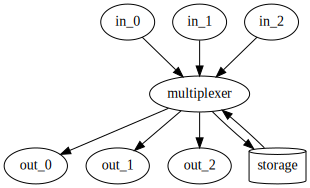

In [4]:
generate_graph(es)

In [5]:

model = Model(es)


storage_multiplexer_constraint(
    model=model,
    name="multiplexer",
    storage_component=storage,
    multiplexer_component=multiplexer,
    input_level_components=[in_0, in_1, in_2],
    output_level_components=[out_0, out_1, out_2],
    levels=[0, 0.5, 1],
)

In [6]:
model.write("bla.lp", io_options = {"symbolic_solver_labels":True})

    solver failure.


('bla.lp', 2001618286000)

In [7]:
model.solve(solver="cbc", solver_io="lp", solve_kwargs={"tee": True, "keepfiles": True})


    solver failure.
Solver log file: 'C:\Users\schl_sk\AppData\Local\Temp\tmpfuk46pha.cbc.log'
Solver solution file: 'C:\Users\schl_sk\AppData\Local\Temp\tmp06magkib.pyomo.soln'
Solver problem files: ('C:\\Users\\schl_sk\\AppData\\Local\\Temp\\tmp06magkib.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Mar  8 2020 

command line - D:\bin\Cbc-2.10.5-win32-msvc15\bin\cbc.exe -printingOptions all -import C:\Users\schl_sk\AppData\Local\Temp\tmp06magkib.pyomo.lp -stat=1 -solve -solu C:\Users\schl_sk\AppData\Local\Temp\tmp06magkib.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-61) rows, 0 (-43) columns and 0 (-135) elements
Statistics for presolved model
Original problem has 6 integers (6 of which binary)


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are -1079676017 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0

{'Problem': [{'Name': 'unknown', 'Lower bound': 0.0, 'Upper bound': 0.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Number of binary variables': 6, 'Number of integer variables': 6, 'Number of nonzeros': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.01, 'Wallclock time': 0.02, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.05599689483642578}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [8]:
from oemof.solph.processing import results, meta_results

In [9]:
my_results = results(model)
for key in my_results:
    print(key)

(0, None)
(0.5, None)
(1, None)
("<oemof.solph.network.bus.Bus: 'in_0'>", "<oemof.solph.network.bus.Bus: 'multiplexer'>")
("<oemof.solph.network.bus.Bus: 'in_1'>", "<oemof.solph.network.bus.Bus: 'multiplexer'>")
("<oemof.solph.network.bus.Bus: 'in_2'>", "<oemof.solph.network.bus.Bus: 'multiplexer'>")
("<oemof.solph.network.bus.Bus: 'multiplexer'>", "<oemof.solph.network.bus.Bus: 'out_0'>")
("<oemof.solph.network.bus.Bus: 'multiplexer'>", "<oemof.solph.network.bus.Bus: 'out_1'>")
("<oemof.solph.network.bus.Bus: 'multiplexer'>", "<oemof.solph.network.bus.Bus: 'out_2'>")
("<oemof.solph.network.bus.Bus: 'multiplexer'>", "<oemof.solph.components.generic_storage.GenericStorage: 'storage'>")
('multiplexer_interval_00', None)
('multiplexer_interval_01', None)
("<oemof.solph.components.generic_storage.GenericStorage: 'storage'>", None)
("<oemof.solph.components.generic_storage.GenericStorage: 'storage'>", "<oemof.solph.network.bus.Bus: 'multiplexer'>")


In [10]:
my_results[(storage, None)]

{'scalars': variable_name
 init_content    0.0
 Name: 2022-01-01 00:00:00, dtype: float64,
 'sequences': variable_name        storage_content
 2022-01-01 00:00:00              0.0
 2022-01-01 01:00:00              0.0
 2022-01-01 02:00:00              0.0}

In [11]:
my_results[(0, None)]

{'scalars': Series([], Name: 2022-01-01 00:00:00, dtype: float64),
 'sequences': variable_name        multiplexer_weights
 2022-01-01 00:00:00                  1.0
 2022-01-01 01:00:00                  1.0
 2022-01-01 02:00:00                  1.0}

In [12]:
my_results[(.5, None)]

{'scalars': Series([], Name: 2022-01-01 00:00:00, dtype: float64),
 'sequences': variable_name        multiplexer_weights
 2022-01-01 00:00:00                  0.0
 2022-01-01 01:00:00                  0.0
 2022-01-01 02:00:00                  0.0}

In [13]:
my_results[(1, None)]

{'scalars': Series([], Name: 2022-01-01 00:00:00, dtype: float64),
 'sequences': variable_name        multiplexer_weights
 2022-01-01 00:00:00                  0.0
 2022-01-01 01:00:00                  0.0
 2022-01-01 02:00:00                  0.0}